# Voice Recognition

In [62]:
!pip install -q numpy pandas librosa matplotlib seaborn scikit-learn tsfel joblib

In [63]:
# ============================================================================
# BAGIAN 1: IMPORT LIBRARIES
# ============================================================================

import numpy as np
import pandas as pd
import librosa
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_selection import mutual_info_classif
import tsfel
import warnings
import joblib
warnings.filterwarnings('ignore')

In [64]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [65]:
# ============================================================================
# BAGIAN 2: SETUP DIREKTORI DAN KONFIGURASI
# ============================================================================

# Folder utama dalam Google Drive
BASE_DIR = "/content/drive/MyDrive/psd"

# Definisi folder mapping manual
FOLDER_MAP = {
    "buka":    ("Diki",   "buka"),     # buka  -> Diki
    "tutup":   ("Diki",   "tutup"),    # tutup -> Diki
    "bukaZ":   ("Zulfri", "buka"),     # bukaZ  -> Zulfri
    "tutupZ":  ("Zulfri", "tutup"),    # tutupZ -> Zulfri
}

print("=" * 80)
print("SISTEM PENGENALAN SUARA - VOICE RECOGNITION")
print("=" * 80)
print(f"Folder dataset: {BASE_DIR}")
print("\nFolder mapping:")
for f, (subj, cmd) in FOLDER_MAP.items():
    print(f"- {f} → Subject: {subj}, Command: {cmd}")

SISTEM PENGENALAN SUARA - VOICE RECOGNITION
Folder dataset: /content/drive/MyDrive/psd

Folder mapping:
- buka → Subject: Diki, Command: buka
- tutup → Subject: Diki, Command: tutup
- bukaZ → Subject: Zulfri, Command: buka
- tutupZ → Subject: Zulfri, Command: tutup


In [66]:
# ============================================================================
# BAGIAN 3: FUNGSI EKSTRAKSI FITUR MENGGUNAKAN TSFEL
# ============================================================================

def extract_features_tsfel(audio_path, sr=22050):
    """
    Ekstraksi fitur audio menggunakan TSFEL
    Returns: 156 fitur (statistical, temporal, spectral)
    """
    try:
        # Load audio
        y, sr = librosa.load(audio_path, sr=sr)

        # Konfigurasi TSFEL untuk ekstraksi semua fitur
        cfg = tsfel.get_features_by_domain()

        # Ekstraksi fitur
        features = tsfel.time_series_features_extractor(
            cfg,
            y,
            fs=sr,
            verbose=0
        )

        return features.values.flatten()

    except Exception as e:
        print(f"Error processing {audio_path}: {str(e)}")
        return None

## Fungsi Augmentasi Data

In [67]:
def add_noise(audio, noise_factor=0.005):
    """Tambahkan white noise ke audio"""
    noise = np.random.randn(len(audio))
    augmented_audio = audio + noise_factor * noise
    return augmented_audio

def time_stretch(audio, rate=1.0):
    """Ubah kecepatan audio tanpa mengubah pitch"""
    return librosa.effects.time_stretch(audio, rate=rate)

def pitch_shift(audio, sr, n_steps=0):
    """Ubah pitch audio"""
    return librosa.effects.pitch_shift(audio, sr=sr, n_steps=n_steps)

def change_volume(audio, factor=1.0):
    """Ubah volume audio"""
    return audio * factor

def time_shift(audio, shift_max=0.2):
    """Shift audio dalam waktu"""
    shift = np.random.randint(int(len(audio) * shift_max))
    direction = np.random.choice(['right', 'left'])
    if direction == 'right':
        return np.pad(audio, (shift, 0), mode='constant')[:-shift]
    else:
        return np.pad(audio, (0, shift), mode='constant')[shift:]

def augment_audio(audio, sr, augmentation_type='noise'):
    """
    Augmentasi audio dengan berbagai metode

    Parameters:
    - audio: numpy array audio
    - sr: sample rate
    - augmentation_type: 'noise', 'pitch_up', 'pitch_down', 'speed_up', 'speed_down', 'louder', 'softer', 'shift'
    """

    if augmentation_type == 'noise':
        return add_noise(audio, noise_factor=0.005)

    elif augmentation_type == 'pitch_up':
        return pitch_shift(audio, sr, n_steps=2)

    elif augmentation_type == 'pitch_down':
        return pitch_shift(audio, sr, n_steps=-2)

    elif augmentation_type == 'speed_up':
        return time_stretch(audio, rate=1.1)

    elif augmentation_type == 'speed_down':
        return time_stretch(audio, rate=0.9)

    elif augmentation_type == 'louder':
        return change_volume(audio, factor=1.2)

    elif augmentation_type == 'softer':
        return change_volume(audio, factor=0.8)

    elif augmentation_type == 'shift':
        return time_shift(audio, shift_max=0.2)

    else:
        return audio

## LOAD DATA DAN EKSTRAKSI FITUR (STRUKTUR PSD)

In [69]:
# ============================================================================
# BAGIAN 4: LOAD DATA DAN EKSTRAKSI FITUR (STRUKTUR PSD)
# ============================================================================

print("\n" + "=" * 80)
print("EKSTRAKSI FITUR DARI AUDIO (DENGAN AUGMENTASI)")
print("=" * 80)

# Konfigurasi augmentasi
APPLY_AUGMENTATION = True  # Set True untuk menggunakan augmentasi
AUGMENTATION_TYPES = ['noise', 'pitch_up', 'pitch_down']  # Pilih jenis augmentasi

print(f"\nAugmentasi: {'AKTIF' if APPLY_AUGMENTATION else 'TIDAK AKTIF'}")
if APPLY_AUGMENTATION:
    print(f"Jenis augmentasi: {AUGMENTATION_TYPES}")
    print(f"Multiplication factor: {len(AUGMENTATION_TYPES) + 1}x (original + {len(AUGMENTATION_TYPES)} augmentasi)")

data = []
labels_command = []
labels_subject = []
file_paths = []
augmentation_info = []  # Untuk tracking augmentasi

# Loop untuk setiap entri di FOLDER_MAP
for folder_key, (subject_label, command_label) in FOLDER_MAP.items():
    folder_path = os.path.join(BASE_DIR, folder_key)

    if not os.path.exists(folder_path):
        print(f"WARNING: Folder tidak ditemukan: {folder_path}")
        continue

    audio_files = [f for f in os.listdir(folder_path) if f.endswith(('.wav', '.mp3', '.flac'))]

    print(f"\nMemproses: {subject_label} - {command_label}")
    print(f"Jumlah file original: {len(audio_files)}")

    original_count = 0
    augmented_count = 0

    for audio_file in audio_files:
        audio_path = os.path.join(folder_path, audio_file)

        # Load audio untuk augmentasi
        try:
            y, sr = librosa.load(audio_path, sr=22050)
        except Exception as e:
            print(f"Error loading {audio_file}: {str(e)}")
            continue

        # 1. Ekstraksi fitur dari ORIGINAL audio
        features = extract_features_tsfel(audio_path)

        if features is not None:
            data.append(features)
            labels_command.append(command_label)
            labels_subject.append(subject_label)
            file_paths.append(audio_path)
            augmentation_info.append('original')
            original_count += 1

        # 2. Ekstraksi fitur dari AUGMENTED audio (jika diaktifkan)
        if APPLY_AUGMENTATION:
            for aug_type in AUGMENTATION_TYPES:
                try:
                    # Augmentasi audio
                    augmented_audio = augment_audio(y, sr, aug_type)

                    # Ekstraksi fitur dari augmented audio
                    cfg = tsfel.get_features_by_domain()
                    features_aug = tsfel.time_series_features_extractor(
                        cfg,
                        augmented_audio,
                        fs=sr,
                        verbose=0
                    )

                    features_aug = features_aug.values.flatten()

                    if features_aug is not None:
                        data.append(features_aug)
                        labels_command.append(command_label)
                        labels_subject.append(subject_label)
                        file_paths.append(f"{audio_path}_{aug_type}")
                        augmentation_info.append(aug_type)
                        augmented_count += 1

                except Exception as e:
                    print(f"Error augmenting {audio_file} with {aug_type}: {str(e)}")

    print(f"  Original: {original_count}")
    if APPLY_AUGMENTATION:
        print(f"  Augmented: {augmented_count}")
        print(f"  Total: {original_count + augmented_count}")

# Konversi ke DataFrame
print("\n" + "=" * 80)
print("MEMBUAT DATAFRAME")
print("=" * 80)

X = np.array(data)
df_features = pd.DataFrame(X)

# Multi-label encoding
df_features['command'] = labels_command
df_features['subject'] = labels_subject

# Membuat label gabungan untuk multi-label classification
df_features['multi_label'] = df_features['subject'] + '_' + df_features['command']

print(f"\nTotal sampel berhasil diproses: {len(df_features)}")
print(f"Total fitur: {X.shape[1]}")
print(f"\nDistribusi data:")
print(df_features['multi_label'].value_counts())


EKSTRAKSI FITUR DARI AUDIO (DENGAN AUGMENTASI)

Augmentasi: AKTIF
Jenis augmentasi: ['noise', 'pitch_up', 'pitch_down']
Multiplication factor: 4x (original + 3 augmentasi)

Memproses: Diki - buka
Jumlah file original: 50
  Original: 50
  Augmented: 150
  Total: 200

Memproses: Diki - tutup
Jumlah file original: 50
  Original: 50
  Augmented: 150
  Total: 200

Memproses: Zulfri - buka
Jumlah file original: 50
  Original: 50
  Augmented: 150
  Total: 200

Memproses: Zulfri - tutup
Jumlah file original: 50
  Original: 50
  Augmented: 150
  Total: 200

MEMBUAT DATAFRAME

Total sampel berhasil diproses: 800
Total fitur: 156

Distribusi data:
multi_label
Diki_buka       200
Diki_tutup      200
Zulfri_buka     200
Zulfri_tutup    200
Name: count, dtype: int64


## VISUALISASI FITUR


STATISTIK FITUR

Jumlah fitur numerik: 156

Statistik deskriptif (5 fitur pertama):
                 0           1           2            3           4
count   800.000000  800.000000  800.000000   800.000000  800.000000
mean    309.137055    0.068591   10.285000   231.718295    0.843708
std     258.918933    0.031374    2.714864   205.922386    0.278544
min       9.146526    0.016425    5.000000     5.641424    0.297220
25%     130.392833    0.045540    8.000000    95.135863    0.669377
50%     232.413633    0.062756   11.000000   171.549764    0.796051
75%     396.252924    0.084306   12.000000   295.973673    0.966493
max    1472.542786    0.196017   25.000000  1259.017847    1.634988


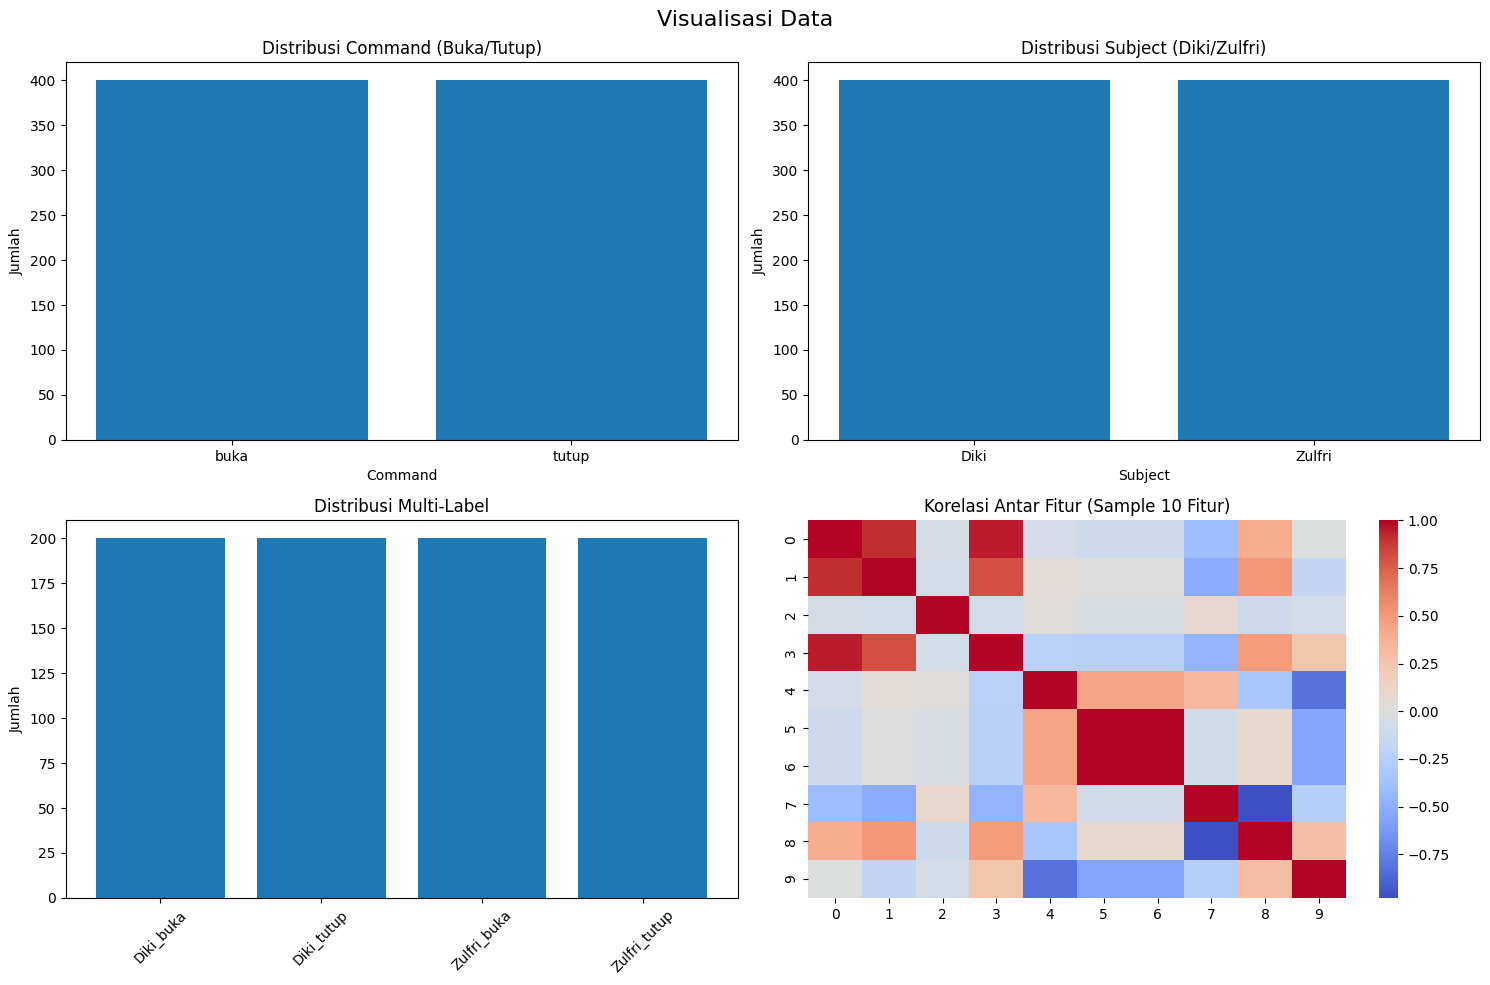

In [70]:
print("\n" + "=" * 80)
print("STATISTIK FITUR")
print("=" * 80)

# Tampilkan statistik fitur
feature_cols = [col for col in df_features.columns if col not in ['command', 'subject', 'multi_label']]
print(f"\nJumlah fitur numerik: {len(feature_cols)}")
print("\nStatistik deskriptif (5 fitur pertama):")
print(df_features[feature_cols[:5]].describe())

# Visualisasi distribusi
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Visualisasi Data', fontsize=16)

# Plot 1: Distribusi label command
axes[0, 0].bar(df_features['command'].value_counts().index,
               df_features['command'].value_counts().values)
axes[0, 0].set_title('Distribusi Command (Buka/Tutup)')
axes[0, 0].set_xlabel('Command')
axes[0, 0].set_ylabel('Jumlah')

# Plot 2: Distribusi label subject
axes[0, 1].bar(df_features['subject'].value_counts().index,
               df_features['subject'].value_counts().values)
axes[0, 1].set_title('Distribusi Subject (Diki/Zulfri)')
axes[0, 1].set_xlabel('Subject')
axes[0, 1].set_ylabel('Jumlah')

# Plot 3: Distribusi multi-label
multi_label_counts = df_features['multi_label'].value_counts()
axes[1, 0].bar(range(len(multi_label_counts)), multi_label_counts.values)
axes[1, 0].set_xticks(range(len(multi_label_counts)))
axes[1, 0].set_xticklabels(multi_label_counts.index, rotation=45)
axes[1, 0].set_title('Distribusi Multi-Label')
axes[1, 0].set_ylabel('Jumlah')

# Plot 4: Heatmap korelasi (sample 10 fitur)
sample_features = df_features[feature_cols[:10]]
corr_matrix = sample_features.corr()
sns.heatmap(corr_matrix, ax=axes[1, 1], cmap='coolwarm', center=0)
axes[1, 1].set_title('Korelasi Antar Fitur (Sample 10 Fitur)')

plt.tight_layout()
plt.show()

## PREPROCESSING

In [71]:
# ============================================================================
# BAGIAN 6: PREPROCESSING
# ============================================================================

print("\n" + "=" * 80)
print("PREPROCESSING DATA")
print("=" * 80)

# Encode labels
le_multi = LabelEncoder()
y_multi = le_multi.fit_transform(df_features['multi_label'])

# Pisahkan fitur dan label
X = df_features[feature_cols].values

# Handle missing values
X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

print(f"\nShape X: {X.shape}")
print(f"Shape y: {y_multi.shape}")
print(f"\nKelas multi-label: {le_multi.classes_}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_multi, test_size=0.2, random_state=42, stratify=y_multi
)

print(f"\nData training: {X_train.shape}")
print(f"Data testing: {X_test.shape}")

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


PREPROCESSING DATA

Shape X: (800, 156)
Shape y: (800,)

Kelas multi-label: ['Diki_buka' 'Diki_tutup' 'Zulfri_buka' 'Zulfri_tutup']

Data training: (640, 156)
Data testing: (160, 156)


##  EXPERIMENT 1 - MENGGUNAKAN SEMUA FITUR


EXPERIMENT 1: MENGGUNAKAN SEMUA FITUR (156 Fitur)

Akurasi dengan SEMUA FITUR: 95.00%

Classification Report (Semua Fitur):
              precision    recall  f1-score   support

   Diki_buka       0.88      0.95      0.92        40
  Diki_tutup       0.95      0.88      0.91        40
 Zulfri_buka       1.00      0.97      0.99        40
Zulfri_tutup       0.98      1.00      0.99        40

    accuracy                           0.95       160
   macro avg       0.95      0.95      0.95       160
weighted avg       0.95      0.95      0.95       160



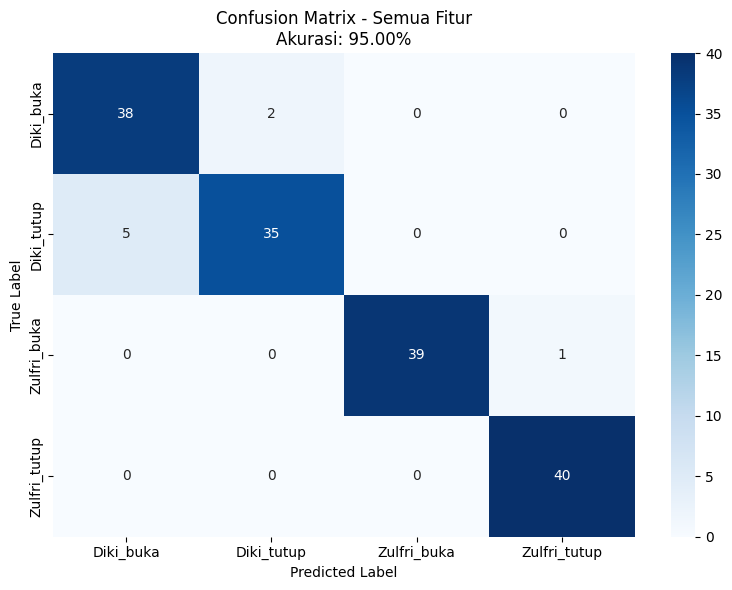

In [72]:
# ============================================================================
# BAGIAN 7: EXPERIMENT 1 - MENGGUNAKAN SEMUA FITUR
# ============================================================================

print("\n" + "=" * 80)
print("EXPERIMENT 1: MENGGUNAKAN SEMUA FITUR (156 Fitur)")
print("=" * 80)

# Model dengan semua fitur
rf_all = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_all.fit(X_train_scaled, y_train)

# Prediksi
y_pred_all = rf_all.predict(X_test_scaled)

# Evaluasi
acc_all = accuracy_score(y_test, y_pred_all)
print(f"\nAkurasi dengan SEMUA FITUR: {acc_all*100:.2f}%")

print("\nClassification Report (Semua Fitur):")
print(classification_report(y_test, y_pred_all, target_names=le_multi.classes_))

# Confusion Matrix
cm_all = confusion_matrix(y_test, y_pred_all)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_all, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_multi.classes_,
            yticklabels=le_multi.classes_)
plt.title(f'Confusion Matrix - Semua Fitur\nAkurasi: {acc_all*100:.2f}%')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


## SELEKSI FITUR MENGGUNAKAN INFORMATION GAIN


SELEKSI FITUR MENGGUNAKAN INFORMATION GAIN

Top 20 Fitur berdasarkan Information Gain:
     feature_idx  mi_score
20            20  0.763014
68            68  0.714301
87            87  0.713771
66            66  0.674721
84            84  0.641517
111          111  0.625981
136          136  0.613109
96            96  0.601350
110          110  0.595423
141          141  0.594754
131          131  0.594754
150          150  0.593983
86            86  0.587105
95            95  0.578815
97            97  0.574942
74            74  0.562317
108          108  0.561804
112          112  0.555103
149          149  0.552300
113          113  0.551738


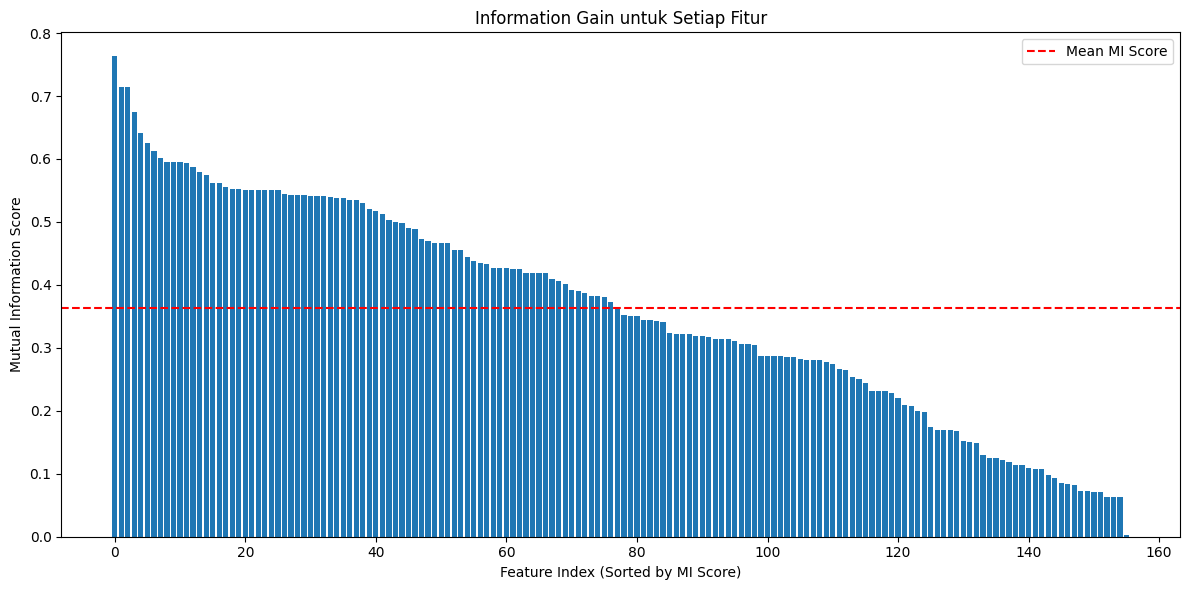


Jumlah fitur terpilih (MI > mean): 78
Threshold MI Score: 0.3625


In [73]:
# ============================================================================
# BAGIAN 8: SELEKSI FITUR MENGGUNAKAN INFORMATION GAIN
# ============================================================================

print("\n" + "=" * 80)
print("SELEKSI FITUR MENGGUNAKAN INFORMATION GAIN")
print("=" * 80)

# Hitung Information Gain (Mutual Information)
mi_scores = mutual_info_classif(X_train_scaled, y_train, random_state=42)

# Buat DataFrame untuk analisis
feature_importance_df = pd.DataFrame({
    'feature_idx': range(len(mi_scores)),
    'mi_score': mi_scores
}).sort_values('mi_score', ascending=False)

print("\nTop 20 Fitur berdasarkan Information Gain:")
print(feature_importance_df.head(20))

# Visualisasi Information Gain
plt.figure(figsize=(12, 6))
plt.bar(range(len(mi_scores)), sorted(mi_scores, reverse=True))
plt.xlabel('Feature Index (Sorted by MI Score)')
plt.ylabel('Mutual Information Score')
plt.title('Information Gain untuk Setiap Fitur')
plt.axhline(y=np.mean(mi_scores), color='r', linestyle='--', label='Mean MI Score')
plt.legend()
plt.tight_layout()
plt.savefig('information_gain.png', dpi=300, bbox_inches='tight')
plt.show()

# Pilih fitur terbaik (threshold: mean MI score)
threshold = np.mean(mi_scores)
selected_features_idx = feature_importance_df[feature_importance_df['mi_score'] > threshold]['feature_idx'].values

print(f"\nJumlah fitur terpilih (MI > mean): {len(selected_features_idx)}")
print(f"Threshold MI Score: {threshold:.4f}")

## EXPERIMENT 2 - MENGGUNAKAN FITUR TERSELEKSI


EXPERIMENT 2: MENGGUNAKAN FITUR TERSELEKSI

Shape data setelah seleksi: (640, 78)

Akurasi dengan FITUR TERSELEKSI: 94.38%

Classification Report (Fitur Terseleksi):
              precision    recall  f1-score   support

   Diki_buka       0.92      0.90      0.91        40
  Diki_tutup       0.90      0.93      0.91        40
 Zulfri_buka       1.00      0.95      0.97        40
Zulfri_tutup       0.95      1.00      0.98        40

    accuracy                           0.94       160
   macro avg       0.94      0.94      0.94       160
weighted avg       0.94      0.94      0.94       160



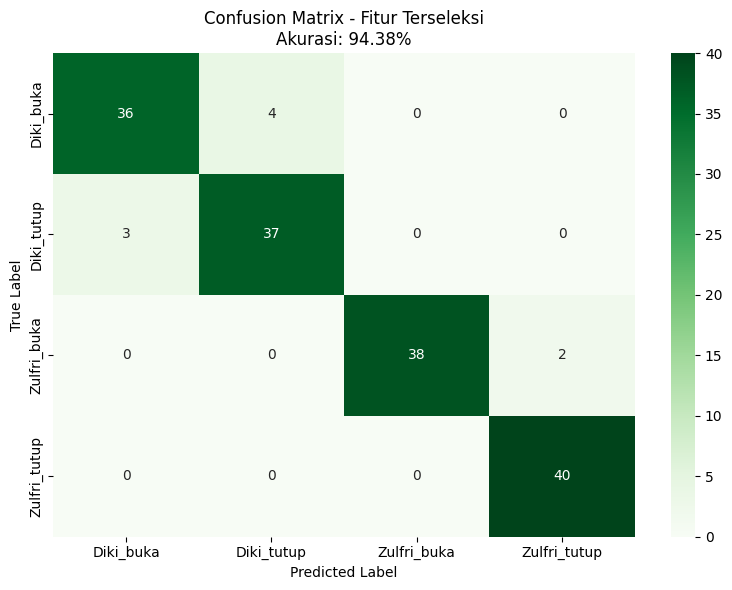

In [74]:
# ============================================================================
# BAGIAN 9: EXPERIMENT 2 - MENGGUNAKAN FITUR TERSELEKSI
# ============================================================================

print("\n" + "=" * 80)
print("EXPERIMENT 2: MENGGUNAKAN FITUR TERSELEKSI")
print("=" * 80)

# Filter fitur
X_train_selected = X_train_scaled[:, selected_features_idx]
X_test_selected = X_test_scaled[:, selected_features_idx]

print(f"\nShape data setelah seleksi: {X_train_selected.shape}")

# Model dengan fitur terseleksi
rf_selected = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_selected.fit(X_train_selected, y_train)

# Prediksi
y_pred_selected = rf_selected.predict(X_test_selected)

# Evaluasi
acc_selected = accuracy_score(y_test, y_pred_selected)
print(f"\nAkurasi dengan FITUR TERSELEKSI: {acc_selected*100:.2f}%")

print("\nClassification Report (Fitur Terseleksi):")
print(classification_report(y_test, y_pred_selected, target_names=le_multi.classes_))

# Confusion Matrix
cm_selected = confusion_matrix(y_test, y_pred_selected)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_selected, annot=True, fmt='d', cmap='Greens',
            xticklabels=le_multi.classes_,
            yticklabels=le_multi.classes_)
plt.title(f'Confusion Matrix - Fitur Terseleksi\nAkurasi: {acc_selected*100:.2f}%')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


PCA TRANSFORMATION (100 Components)

Shape setelah PCA: (640, 100)
Total variance explained: 99.99%


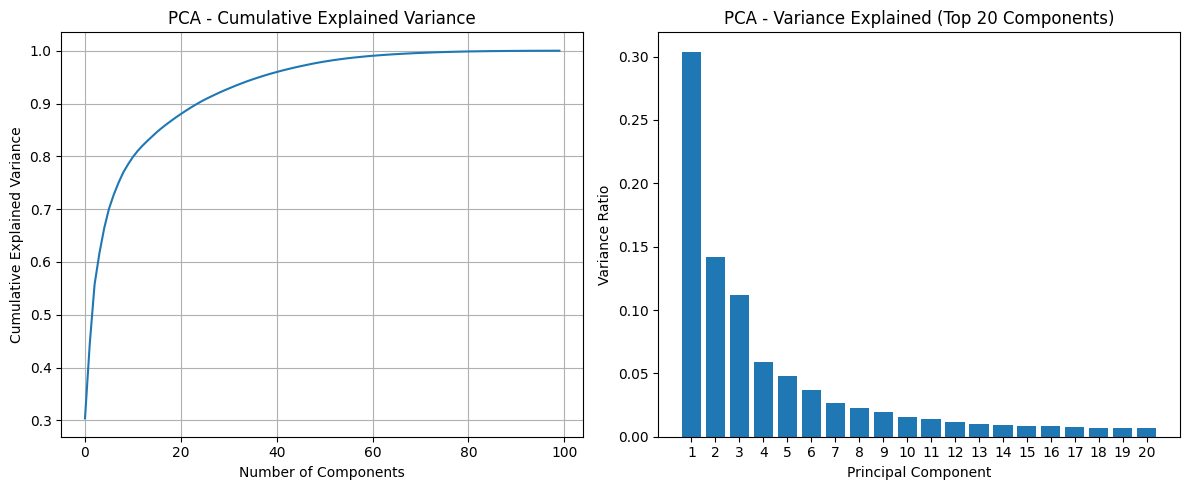


Akurasi dengan PCA (100 components): 94.38%

Classification Report (PCA):
              precision    recall  f1-score   support

   Diki_buka       0.97      0.88      0.92        40
  Diki_tutup       0.88      0.93      0.90        40
 Zulfri_buka       1.00      0.97      0.99        40
Zulfri_tutup       0.93      1.00      0.96        40

    accuracy                           0.94       160
   macro avg       0.95      0.94      0.94       160
weighted avg       0.95      0.94      0.94       160



In [88]:
# ============================================================================
# BAGIAN 10: PCA TRANSFORMATION (100 COMPONENTS)
# ============================================================================

print("\n" + "=" * 80)
print("PCA TRANSFORMATION (100 Components)")
print("=" * 80)

# Terapkan PCA pada semua fitur (156 fitur)
pca = PCA(n_components=100, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Membuat DataFrame PCA 2D untuk visualisasi
X_train_pca_2d = X_train_pca[:, :2]  # Ambil PC1 dan PC2

df_pca = pd.DataFrame({
    "PC1": X_train_pca_2d[:, 0],
    "PC2": X_train_pca_2d[:, 1],
    "nama_label": le_multi.inverse_transform(y_train) # Use inverse_transform to get original labels from encoded y_train
})

print(f"\nShape setelah PCA: {X_train_pca.shape}")
print(f"Total variance explained: {pca.explained_variance_ratio_.sum()*100:.2f}%")

# Visualisasi explained variance
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Cumulative Explained Variance')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.bar(range(1, 21), pca.explained_variance_ratio_[:20])
plt.xlabel('Principal Component')
plt.ylabel('Variance Ratio')
plt.title('PCA - Variance Explained (Top 20 Components)')
plt.xticks(range(1, 21))

plt.tight_layout()
# plt.savefig('pca_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Model dengan PCA
rf_pca = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_pca.fit(X_train_pca, y_train)

# Prediksi
y_pred_pca = rf_pca.predict(X_test_pca)

# Evaluasi
acc_pca = accuracy_score(y_test, y_pred_pca)
print(f"\nAkurasi dengan PCA (100 components): {acc_pca*100:.2f}%")

print("\nClassification Report (PCA):")
print(classification_report(y_test, y_pred_pca, target_names=le_multi.classes_))

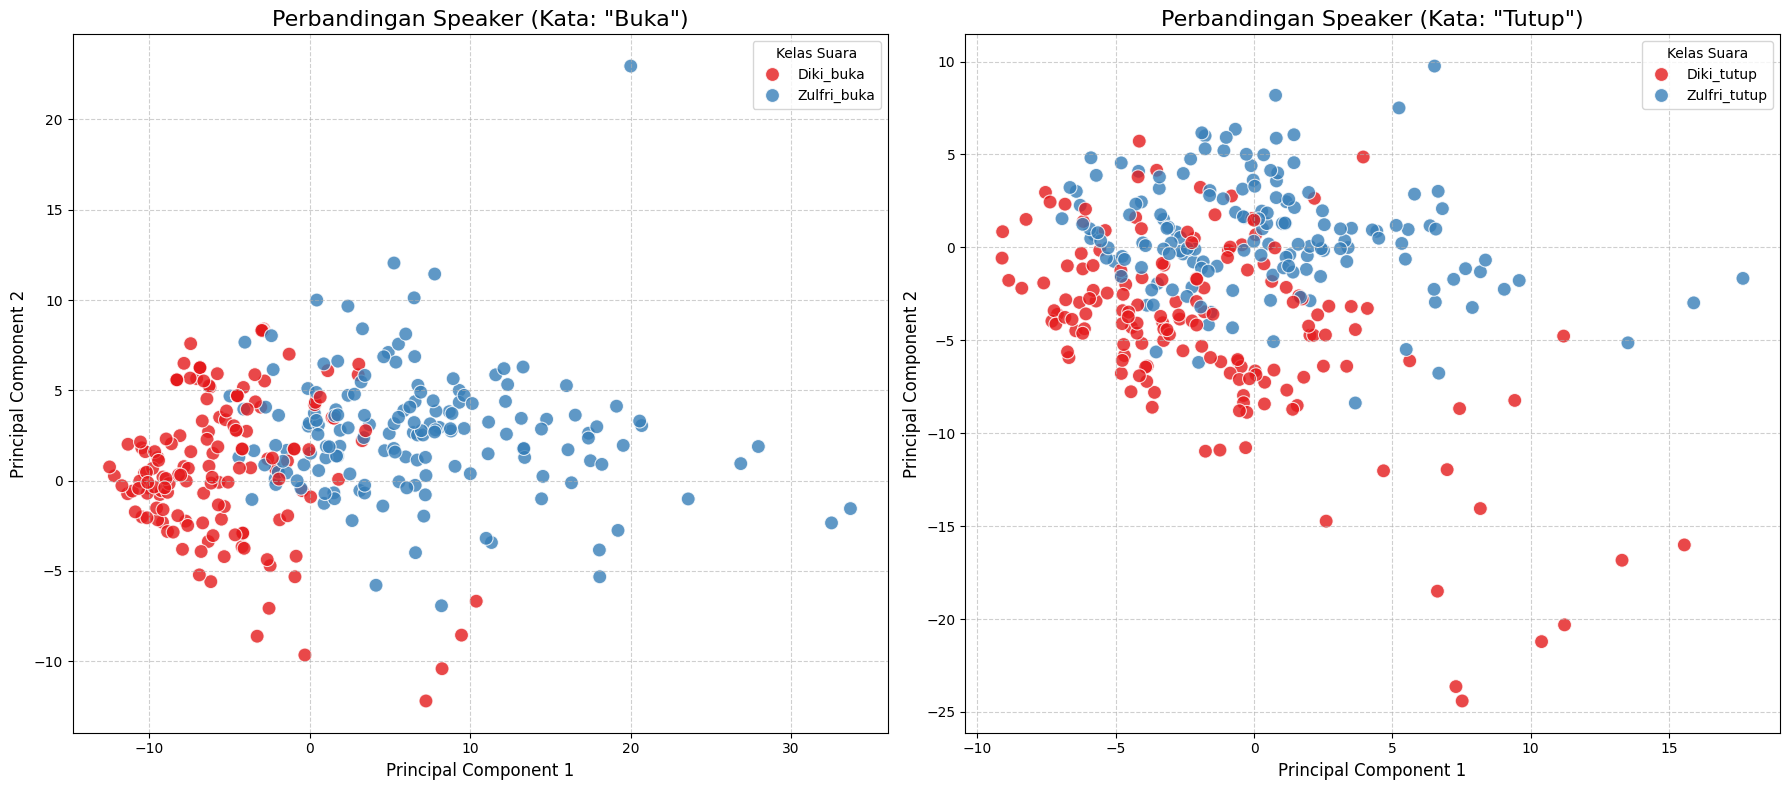

In [89]:
# ----------------------------------------------------------------------
# VISUALISASI PERBANDINGAN SPEAKER (BUKA vs TUTUP)
# ----------------------------------------------------------------------

# Atur figur agar memiliki 2 subplot berdampingan
plt.figure(figsize=(18, 8))

# --- PLOT 1: Perbandingan untuk kata "Buka" ---
plt.subplot(1, 2, 1) # 1 baris, 2 kolom, plot ke-1

# Filter data: hanya ambil label 'Diki_buka' dan 'Zulfri_buka'
data_buka = df_pca[df_pca['nama_label'].isin(['Diki_buka', 'Zulfri_buka'])]

sns.scatterplot(
    data=data_buka,
    x='PC1',
    y='PC2',
    hue='nama_label',
    palette='Set1', # Gunakan palet warna yang jelas
    s=100,
    alpha=0.8
)
plt.title('Perbandingan Speaker (Kata: "Buka")', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Kelas Suara')


# --- PLOT 2: Perbandingan untuk kata "Tutup" ---
plt.subplot(1, 2, 2) # 1 baris, 2 kolom, plot ke-2

# Filter data: hanya ambil label 'Diki_tutup' dan 'Zulfri_tutup'
data_tutup = df_pca[df_pca['nama_label'].isin(['Diki_tutup', 'Zulfri_tutup'])]

sns.scatterplot(
    data=data_tutup,
    x='PC1',
    y='PC2',
    hue='nama_label',
    palette='Set1', # Gunakan palet yang sama
    s=100,
    alpha=0.8
)
plt.title('Perbandingan Speaker (Kata: "Tutup")', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Kelas Suara')

# Tampilkan kedua plot
plt.tight_layout()
plt.show()

## PERBANDINGAN HASIL EXPERIMENT


PERBANDINGAN HASIL SEMUA EXPERIMENT

             Method  Num Features  Accuracy (%)
 Semua Fitur (156)           156        95.000
Seleksi Fitur (IG)            78        94.375
    PCA (100 comp)           100        94.375


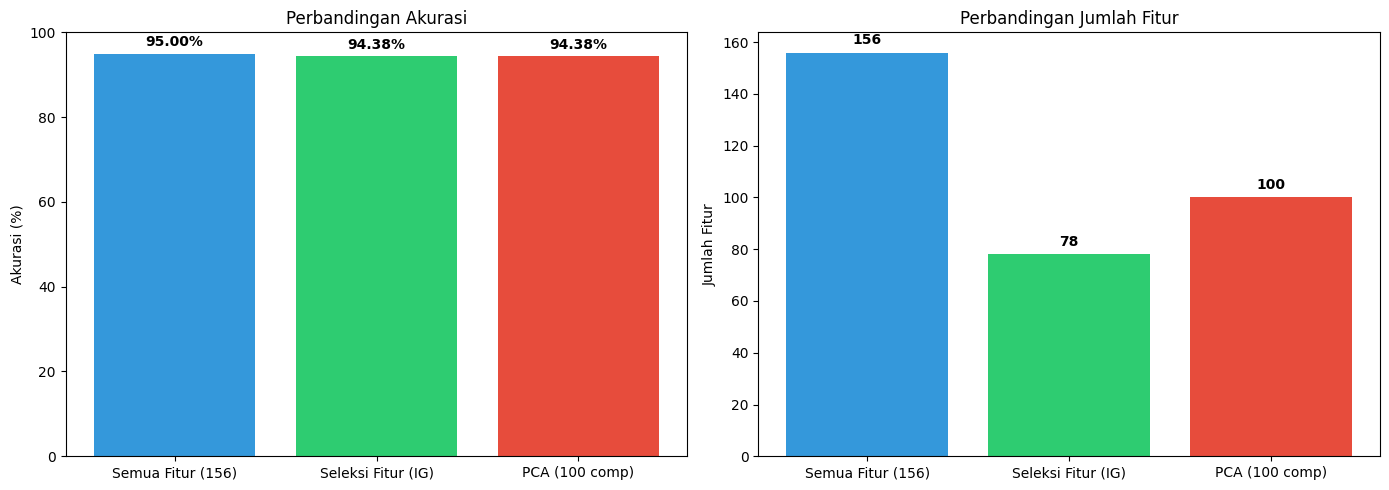

In [85]:
# ============================================================================
# BAGIAN 11: PERBANDINGAN HASIL EXPERIMENT
# ============================================================================

print("\n" + "=" * 80)
print("PERBANDINGAN HASIL SEMUA EXPERIMENT")
print("=" * 80)

results = {
    'Method': ['Semua Fitur (156)', 'Seleksi Fitur (IG)', 'PCA (100 comp)'],
    'Num Features': [X.shape[1], len(selected_features_idx), 100],
    'Accuracy (%)': [acc_all*100, acc_selected*100, acc_pca*100]
}

df_results = pd.DataFrame(results)
print("\n", df_results.to_string(index=False))

# Visualisasi perbandingan
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Akurasi
axes[0].bar(df_results['Method'], df_results['Accuracy (%)'],
            color=['#3498db', '#2ecc71', '#e74c3c'])
axes[0].set_ylabel('Akurasi (%)')
axes[0].set_title('Perbandingan Akurasi')
axes[0].set_ylim([0, 100])
for i, v in enumerate(df_results['Accuracy (%)']):
    axes[0].text(i, v + 1, f'{v:.2f}%', ha='center', va='bottom', fontweight='bold')

# Plot 2: Jumlah Fitur
axes[1].bar(df_results['Method'], df_results['Num Features'],
            color=['#3498db', '#2ecc71', '#e74c3c'])
axes[1].set_ylabel('Jumlah Fitur')
axes[1].set_title('Perbandingan Jumlah Fitur')
for i, v in enumerate(df_results['Num Features']):
    axes[1].text(i, v + 2, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## SAVE MODEL DAN PREPROCESSING OBJECTS

In [93]:
# ============================================================================
# BAGIAN 12: SAVE MODEL DAN PREPROCESSING OBJECTS
# ============================================================================

print("\n" + "=" * 80)
print("MENYIMPAN MODEL DAN OBJECTS")
print("=" * 80)

# Simpan model terbaik (pilih yang akurasi tertinggi)
best_models = {
    'all_features': (rf_all, acc_all, 'semua_fitur'),
    'selected_features': (rf_selected, acc_selected, 'seleksi_fitur'),
    'pca': (rf_pca, acc_pca, 'pca')
}

best_method = max(best_models.items(), key=lambda x: x[1][1])
best_model_name = best_method[0]
best_model, best_acc, best_desc = best_method[1]

print(f"\nModel terbaik: {best_desc}")
print(f"Akurasi: {best_acc*100:.2f}%")

# Save objects
joblib.dump(best_model, 'model_best.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(le_multi, 'label_encoder.pkl')
joblib.dump(selected_features_idx, 'selected_features.pkl')
joblib.dump(pca, 'pca.pkl')

# Save info model
model_info = {
    'best_method': best_model_name,
    'accuracy': best_acc,
    'num_features': len(selected_features_idx) if best_model_name == 'selected_features' else (100 if best_model_name == 'pca' else X.shape[1]),
    'classes': le_multi.classes_.tolist()
}

import json
with open('model_info.json', 'w') as f:
    json.dump(model_info, f, indent=4)

print("\nFile yang disimpan:")
print("- model_best.pkl")
print("- scaler.pkl")
print("- label_encoder.pkl")
print("- selected_features.pkl")
print("- pca.pkl")
print("- model_info.json")



MENYIMPAN MODEL DAN OBJECTS

Model terbaik: semua_fitur
Akurasi: 95.00%

File yang disimpan:
- model_best.pkl
- scaler.pkl
- label_encoder.pkl
- selected_features.pkl
- pca.pkl
- model_info.json


In [91]:
# ============================================================================
# BAGIAN 13: FUNGSI PREDIKSI UNTUK AUDIO BARU
# ============================================================================

def predict_new_audio(audio_path, method='best'):
    """
    Fungsi untuk memprediksi audio baru

    Parameters:
    - audio_path: path ke file audio
    - method: 'all_features', 'selected_features', atau 'pca'
    """
    # Load objects
    model = joblib.load('model_best.pkl')
    scaler = joblib.load('scaler.pkl')
    le = joblib.load('label_encoder.pkl')

    # Ekstraksi fitur
    features = extract_features_tsfel(audio_path)

    if features is None:
        return None

    # Reshape dan scale
    features = features.reshape(1, -1)
    features = np.nan_to_num(features, nan=0.0, posinf=0.0, neginf=0.0)
    features_scaled = scaler.transform(features)

    # Load model info untuk menentukan method
    with open('model_info.json', 'r') as f:
        model_info = json.load(f)

    best_method = model_info['best_method']

    # Terapkan transformasi sesuai method
    if best_method == 'selected_features':
        selected_idx = joblib.load('selected_features.pkl')
        features_final = features_scaled[:, selected_idx]
    elif best_method == 'pca':
        pca_model = joblib.load('pca.pkl')
        features_final = pca_model.transform(features_scaled)
    else:
        features_final = features_scaled

    # Prediksi
    prediction = model.predict(features_final)
    prediction_proba = model.predict_proba(features_final)

    # Decode label
    predicted_label = le.inverse_transform(prediction)[0]

    # Parse label
    subject, command = predicted_label.split('_')

    result = {
        'subject': subject,
        'command': command,
        'full_label': predicted_label,
        'confidence': np.max(prediction_proba) * 100,
        'all_probabilities': {
            le.classes_[i]: prediction_proba[0][i] * 100
            for i in range(len(le.classes_))
        }
    }

    return result

# Test fungsi prediksi (contoh)
print("\n" + "=" * 80)
print("TEST FUNGSI PREDIKSI")
print("=" * 80)
print("\nFungsi predict_new_audio() siap digunakan!")
print("\nContoh penggunaan:")
print("result = predict_new_audio('path/to/audio.wav')")
print("print(f\"Subject: {result['subject']}\")")
print("print(f\"Command: {result['command']}\")")
print("print(f\"Confidence: {result['confidence']:.2f}%\")")

print("\n" + "=" * 80)
print("PROSES SELESAI!")
print("=" * 80)
print("\nSilakan lanjutkan ke deployment Streamlit dengan file yang sudah disimpan.")


TEST FUNGSI PREDIKSI

Fungsi predict_new_audio() siap digunakan!

Contoh penggunaan:
result = predict_new_audio('path/to/audio.wav')
print(f"Subject: {result['subject']}")
print(f"Command: {result['command']}")
print(f"Confidence: {result['confidence']:.2f}%")

PROSES SELESAI!

Silakan lanjutkan ke deployment Streamlit dengan file yang sudah disimpan.
